In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import numpy as np

import corner
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from src.likelihood import LogLikelihood
from src.velocity import velocity

In [3]:
apstar_id = 'apogee.lco25m.stars.SMC1.2M00243926-7735213'
apstar_id = 'apogee.lco25m.stars.47TUC.2M00244062-7248266'

# Download data (ONLY RUN IF YOU DON'T HAVE DATA)

In [5]:
from src.data.download import get_visitIds_from_apstarId, get_rvs_from_visit_id

visit_ids = get_visitIds_from_apstarId(apstar_id)['visit_id']
all_data = [get_rvs_from_visit_id(str(list(visit_ids)[i])) for i in range(len(visit_ids))]
data = dict()
data[apstar_id] = {
    'jd' : [float(entry['jd']) for entry in all_data],
    'vhelio' : [float(entry['vhelio']) for entry in all_data],
    'vrelerr' : [float(entry['vrelerr']) for entry in all_data]
}

with open(f'{apstar_id}.pkl', 'wb') as f:
    pickle.dump(data, f)

/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_50467/4036752921.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'jd' : [float(entry['jd']) for entry in all_data],
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_50467/4036752921.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'vhelio' : [float(entry['vhelio']) for entry in all_data],
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_50467/4036752921.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (D

# Load data

In [33]:
with open(f'{apstar_id}.pkl', 'rb') as f:
    data = pickle.load(f)

print(data)

{'apogee.lco25m.stars.47TUC.2M00244062-7248266': {'jd': [2458291.91079, 2458294.91963, 2458322.81616, 2458384.66226, 2458292.92051, 2458295.86918, 2458323.8265, 2458297.884, 2458353.73546, 2458356.71607, 2458298.86821, 2458416.56691, 2458419.57348, 2458417.56904, 2458440.51701, 2458443.52048, 2458418.56965, 2458441.51792, 2458444.50379], 'vhelio': [127.818, 127.8947, 127.7336, 127.9952, 127.8862, 128.025, 127.5529, 127.9344, 127.2612, 127.5466, 128.2253, 128.7791, 128.9567, 129.1851, 129.3264, 129.7897, 129.048, 129.6871, 129.7148], 'vrelerr': [0.05614301, 0.12871, 0.1142815, 0.1015385, 0.0598397, 0.06265335, 0.07810376, 0.06381803, 0.1000587, 0.04751742, 0.06561189, 0.0731445, 0.06628081, 0.07119136, 0.05860481, 0.05487638, 0.06089327, 0.07565644, 0.09766455]}}


Text(0, 0.5, 'vhelio')

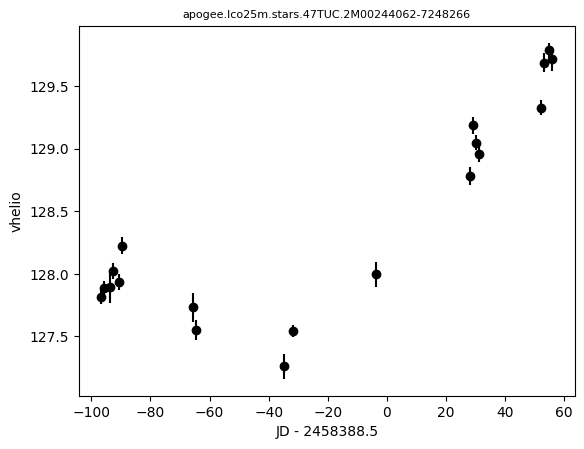

In [34]:
time = jnp.array(data[apstar_id]['jd'])
observed_data = jnp.array(data[apstar_id]['vhelio'])
uncertainty = jnp.array(data[apstar_id]['vrelerr'])

fiducial_jd = 2457388.5 + 1000
# plt.scatter(time - fiducial_jd, observed_data, color='black', marker='o')
plt.errorbar(time - fiducial_jd, observed_data, yerr=uncertainty, color='black', linestyle=' ', marker='o')
plt.title(f'{apstar_id}', fontsize=8)
plt.xlabel(f'JD - {fiducial_jd}')
plt.ylabel('vhelio')

# Construct Posterior Samples w/ Joker

In [12]:
import thejoker as tj
import astropy
import astropy.units as u


<Axes: xlabel='time [BMJD]', ylabel='RV [$\\mathrm{km\\,s^{-1}}$]'>

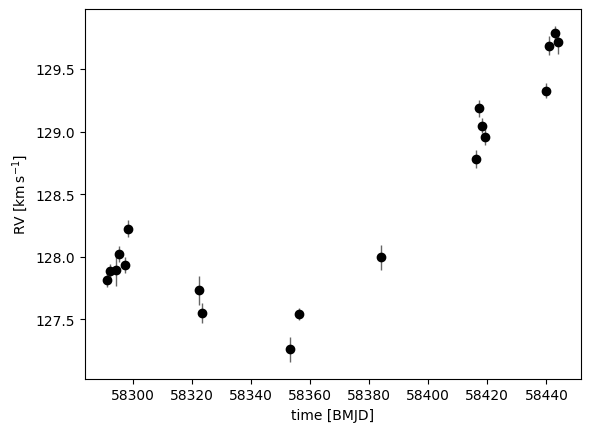

In [32]:
t = astropy.time.Time(time, format="jd", scale="tcb") 

data_tj = tj.RVData(
    t=t, 
    rv=observed_data * u.km/u.s, 
    rv_err=uncertainty * u.km/u.s,
)
data_tj.plot()

In [20]:
rnd = np.random.default_rng(seed=42)

prior = tj.JokerPrior.default(
    P_min=2*u.day, P_max=256*u.day,
    sigma_K0=30*u.km/u.s,
    sigma_v=100*u.km/u.s
)
prior_samples = prior.sample(size=250_000, rng=rnd)

In [ ]:
joker = tj.TheJoker(prior, rng=rnd)
joker_samples = joker.rejection_sample(data_tj, prior_samples, max_posterior_samples=256 * 2)

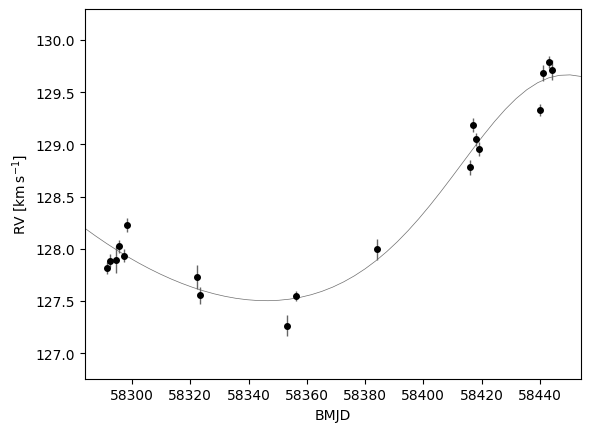

In [22]:
_ = tj.plot_rv_curves(joker_samples, data=data)

In [44]:
joker_samples.tbl.to_pandas().iloc[0].values

array([ 2.36876218e+02,  1.76608431e-01, -6.01980131e-01, -2.51761082e+00,
        0.00000000e+00,  1.08183884e+00,  1.28427033e+02])

# Construct Likelihood

In [24]:
from src.likelihood import LogLikelihood

In [35]:
loglikelihood = LogLikelihood(
    times=jnp.array(data[apstar_id]['jd'], dtype=jnp.float64),
    observed_data=jnp.array(data[apstar_id]['vhelio'], dtype=jnp.float64),
    uncertainity=jnp.array(data[apstar_id]['vrelerr'], dtype=jnp.float64),
)

# Sampler

In [45]:
from hemcee.kernels.hmc_walk_dual_averaging import hamiltonian_walk_move_dual_averaging

In [80]:
# Setup
init_bounds = jnp.array(
    [
        [230, 250],
        [0.1, 0.3],
        [0.0, 1.0],
        [-10.0, 10.0], 
        [0.0, 10.0], 
        [120.0, 130.0]
    ]
)


n_samples = 1000
n_warmup = 1000

samples, acceptance_rates, final_epsilon, logs = hamiltonian_walk_move_dual_averaging(
    lambda x: -loglikelihood(x), 
    init_bounds=init_bounds, 
    n_samples=n_samples,
    n_chains_per_group = 6 * 5,
    L=4, 
    n_thin=1,
    n_warmup=n_warmup,
    target_accept=0.65, # Dual Averaging parameters
    t0=10.0,
    kappa=0.75,
    )

print('Acceptance Rates')
print(acceptance_rates)
print('Final Step Size Chosen')
print(final_epsilon)

TypeError: hamiltonian_walk_move_dual_averaging() got an unexpected keyword argument 'init_bounds'

In [78]:
logs[1], logs[2]

(Array([[ 1.58378416e-01, -1.67326629e+00,  3.31331374e-01,
         -9.63311359e-01,  1.34303002e+00,  7.93351135e-01,
         -7.34752065e-01, -1.39606541e-01,  1.29687073e-02,
          6.89170983e-01, -6.65063869e-01, -9.58534896e-01,
          2.58486302e-01, -5.32371054e-01,  2.13222142e-02,
         -1.04527450e-01,  1.16221299e+00, -5.17111391e-01,
          1.06594516e+00,  4.18951512e-01, -1.02585528e+00,
         -4.47477182e-01, -6.79982021e-02, -2.21083791e-01,
         -1.53206577e+00,  5.22694236e-01,  1.25678309e+00,
         -1.06665078e+00,  4.93131515e-01, -8.54289550e-01],
        [ 2.55241615e-01, -1.89482715e+00, -1.08979046e+00,
          3.92026448e-01,  1.13141188e+00,  2.02979567e+00,
         -2.10705127e-01, -2.96436924e-01,  2.91844030e-01,
         -2.11456086e-01, -4.75421212e-01,  1.23522256e+00,
         -1.21246976e-01,  6.51659428e-01,  8.15432626e-01,
          7.35550641e-01, -8.03134442e-01, -2.23483681e+00,
          1.44832524e+00, -4.56270974e-

In [68]:
threshold = 0.01
mask = acceptance_rates >= threshold
filtered_samples = samples[:, mask, :]
filtered_acceptance = acceptance_rates[mask]
print(filtered_acceptance)

corner.corner(
    np.array(filtered_samples.reshape(-1, 6)),
    labels=["period", "eccentricity", "omega", "phi0", "K", "v0"],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
)

[]


/Users/clarkmiyamoto/miniconda3/envs/thejoker/lib/python3.13/site-packages/arviz/data/base.py:272: UserWarning: More chains (1) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


AssertionError: I don't believe that you want more dimensions than samples!